# Implementing ANN using Tensorflow - Final Project
## Using a Convolutional Neural Network for genre Classification in music
---

by Group 03 - Lea Doppertin and Sven Groen

We are trying to recreate the results achieved by:

http://cs229.stanford.edu/proj2018/report/21.pdf

---

# Introduction

Here is a nice introduction about what we are doing

## Related Work

Here is some stuff that is related to our topic

## Importing Librarys

In [2]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
from sklearn import preprocessing
from collections import defaultdict
from librosa import display

# The raw Dataset

The GTZAN dataset was also used by Huang, Serafini and Pugh [1]. It consists of 1000 wav-audio files with each 30 secounds of length. They are sorted by musical genre. 

## Loading the Data in Python

### creating a csv for easier use

Having the data in a Pandas Dataframe format makes it easier to access the files.

In [3]:
genre_directory = os.getcwd() + "\data\genres"

#get the labels (all Genres)
for dirpath, dirname, filename in os.walk(genre_directory):
    labels = dirname
    break

# creating touple dataset
data = []
for genre in labels:
    path = genre_directory + "\\" + genre
    for dirpath, dirnames, filenames in os.walk(path):
        for file in filenames:
            data.append((file,"data/genres/"+genre+"/"+file , genre))
            
#"data/genres/" + genre

In [4]:
df = pd.DataFrame(data, columns = ["filename","path","genre"])
df.head()

,filename,path,genre
0,blues.00000.wav,data/genres/blues/blues.00000.wav,blues
1,blues.00001.wav,data/genres/blues/blues.00001.wav,blues
2,blues.00002.wav,data/genres/blues/blues.00002.wav,blues
3,blues.00003.wav,data/genres/blues/blues.00003.wav,blues
4,blues.00004.wav,data/genres/blues/blues.00004.wav,blues


In [5]:
print("Our Dataset consists of {} files.".format(len(df)))
print("The Genres are: {}".format(df.genre.unique()))

Our Dataset consists of 1000 files.
The Genres are: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


### example Datapoint

In [6]:
signals = []
sampling_rates=[]
for file in df["path"]:
    signal,sampling_rate= lb.load(file)
    signals.append(signal)
    sampling_rates.append(sampling_rate)

In [7]:
sampling_rates = set(sampling_rates)
print("The Sampling rate is equal across all audio files. It is: {}".format(sampling_rates))

The Sampling rate is equal across all audio files. It is: {22050}


In [8]:
# Lets hear a random example
ipd.Audio(np.random.choice(signals),rate=sampling_rate)

# Preprocessing

In [1] the Authors did some preprocessing to the audio in order to achieve better results:

>"From each clip, we sampled a
contiguous 2-second window at four random locations, thus augmenting our data to 8000 clips of two seconds each.
Since this data was sampled at 22050HZ, this leaves us with 44100 features for the raw audio input. We restricted
our windows to two seconds to limit the number of features. We found that 44100 features was the perfect balance
between length of audio sample and dimension of feature space. Thus after pre-processing our input is of shape (8000,
CS229 Final Report - Music Genre Classification
44100), where each feature denotes the amplitude at a certain timestep out of the 44100. We also used 100 samples of
un-augmented data each of our cross validation and test sets."

## 2-second random samples

We need to sample contiguous 2-second window at four random locations.
To get the duration of each signal in seconds we need to divide it by the sampling rate:

$\frac{len(signal)}{sampling\_rate} = duration_{sec.}$

$\Leftrightarrow len(signal) = duration_{sec.} * sampling\_rate$


In [9]:
len_signal = 2 * sampling_rate
print("To receive 2 second random clips from our audio signal, we have to look at {} continous entries in our raw numpy signal.".format(len_signal))

To receive 2 second random clips from our audio signal, we have to look at 44100 continous entries in our raw numpy signal.


To achieve this we pick one random starting index (and make sure it can maximialy be at 28 seconds) and return the signal from that point on for 2 seconds:

In [10]:
# get a random starting point in the 30 sec. clip
def get_rand_sample(signal,duration,sr=22050):
    ''' samples a random part of a signal
    
    Parameters:
        signal (np.array): the signal from which a random sample should be drawn
        duration (int): how long the sample should be (in seconds)
    
    returns:
        np.array:  random part of signal of length duration (in seconds)
    
    '''
    
    len_signal=duration * sr
    rand_index = np.random.randint(len(signal)-len_signal+1,size=1)[0]
    
    return signal[rand_index: rand_index+len_signal]

### Example

In [11]:
example = get_rand_sample(signals[np.random.randint(len(signals))],2,sr=sampling_rate)
assert(len(example)/sampling_rate==2.0)
ipd.Audio(example, rate=sampling_rate)

## Creating our training audio samples

Now we need 4 of these 2 second samples for each file. We do this by calling our `get_rand_samples()` function 4 times.

In [12]:
data = defaultdict(list)

# for each .wav -file in our raw dataset
for i,file in enumerate(df["path"]):
    
    # load the signal and the sampling rate (sr is identical for all files)
    signal,sr = lb.load(file)
    # fill a dict. with the genres as key and list of 2 sec. samples from the audio files as values
    [data[df.iloc[i]["genre"]].append(get_rand_sample(signal=signal,duration=2,sr=sr)) for _ in range(4)] #get 4 samples

In [13]:
# since our raw dataset consisted of 1000 raw audio files from which we took 4 samples for each audio files we should have 4000 samples:
i=0
for genre in data:
    for entry in data[genre]:
        i+=1
assert i == len(df)*4

## Mel-Spectograms

The original authors converted the raw audio signal into mel-spectograms.
To get the mel-spectogram we use librosas [melspectrogram()](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html) method

When it comes to the parameters the authors say that they chose the following parameters:
> 64 mel-bins and a window length of 512 samples with an
overlap of 50% between windows. Based on previous academic success with such transformations, we then move to
log-scaling using the formula $log(X^2)$.

Moreover, the authors stated, that they converted the "raw" audio into mel-spectograms, we are sure they they refer to the 2 second random clips and not the 30 sec. clips. We assume this since the resulting spectogram which you will see below for 2 sec looks exactly like the authores showed in their paper. The "raw" 30 sec. melspectogram looks not like the spectograms in the paper, however, we will investigate these later on.

In [14]:
# Fixing parameters
N_MELS = 64
SR = sampling_rate
N_FFT = 512 # window length
HOP_LENGTH = N_FFT // 2 # "50% overlap between the windows"

In [15]:
# converts to log decibel
mel_log = lambda x: lb.power_to_db(x**2) 

Let's look at one random example:

In [16]:
mel = lb.feature.melspectrogram(data["blues"][5],sr=SR,n_fft=N_FFT,hop_length=HOP_LENGTH,n_mels=N_MELS)

There are different approaches to visualize these mel-spectograms. Either Matplotlib [plt.imshow](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html) method (used by the authors) or librosa built in plotting function [specshow](https://librosa.github.io/librosa/generated/librosa.display.specshow.html#librosa.display.specshow). Below you can see how the log mel-spectograms differ:


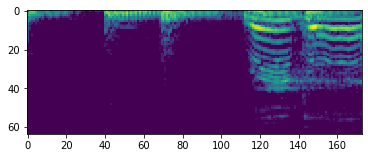

In [17]:
plt.imshow(mel_log(mel))

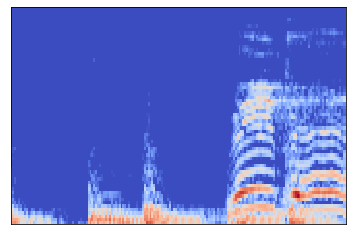

In [18]:
lb.display.specshow(mel_log(mel))

The resulting Images are basically the same except that the [plt.imshow](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html) plots the image on a "upside down" y-axis (from 60 to 0).

### creating the image dataset

We decided to use the [plt.imshow](https://matplotlib.org/3.1.3/api/_as_gen/matplotlib.pyplot.imshow.html) method since it was also used by the authors. To create the dataset, we iterate through all files and save their respectve mel-spectogram images.

In [19]:
# saving the images

count=0 # used for naming the files

# storing path and labels as touples
data_images = []

# for genre in data:
for genre in labels:
    # for each entry in the dictionary
    for sample in data[genre]:
        # check if file already exists
        if not os.path.isfile("data/images/preprocessed/melspectogram_"+str(genre)+ "_" + str(count) +".png"):
            # extract the mel-feature, create the spectogram and save the image
            mel = lb.feature.melspectrogram(sample,sr=SR,n_fft=N_FFT,hop_length=HOP_LENGTH,n_mels=N_MELS)
            plt.imshow(mel_log(mel))
            plt.savefig("data/images/preprocessed/melspectogram_"+str(genre)+ "_" + str(count) +".png")
            
        # append the path of the saved files and the corresponding label (genre) as a tuple for later acces
        data_images.append(("\\data\\images\\preprocessed\\melspectogram_"+str(genre)+ "_" + str(count) +".png", genre))
        count +=1

In [27]:
path = os.getcwd()

img_list = []
genre_list=[]
img_tensor_list = []

# iterate through the tuples
for file, genre in data_images:
    # load the .png files and save them as np.arrays
    img=tf.io.read_file(path+file)
    img=tf.image.decode_png(img,channels=3) #RGB only (no alpha levels)
    img = tf.image.convert_image_dtype(img, dtype=np.float32) # convert to float and normalize
    img_tensor_list.append(img)
    img = img.numpy()
    
    img_list.append(img)
    genre_list.append(genre)

## One Hot Encode Labels

Currently our Labels/Targets are just strings. We transfor it into a vector representation using a labelencoder and a One-Hot-Encoder to generate targets that can be used for machine learning.

In [40]:
genre_list = pd.DataFrame(genre_list)
lbl_enc = preprocessing.LabelEncoder()
genre_list=genre_list.apply(lbl_enc.fit_transform)
oh_enc = preprocessing.OneHotEncoder()
genre_list = oh_enc.fit_transform(genre_list).toarray()

TypeError: argument must be a string or number

## Training and Test data

With our preprocessing done, we can divide out Dataset into Training and Testing data. We used a 80:20 ratio of training:testing.

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_list, genre_list, test_size=0.2)

In [25]:
# transform into np.array()
X_train = np.array(X_train)
X_test = np.array(X_test)



numpy.ndarray

In [41]:
img_tensor_list = tf.convert_to_tensor(img_tensor_list)
genre_list2 = tf.convert_to_tensor(genre_list)
X_train2, X_test2, y_train2, y_test2 = train_test_split(img_tensor_list, genre_list2, test_size=0.2)

ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "C:\Users\SvenG\.conda\envs\ann\lib\site-packages\tensorflow_core\python\framework\ops.py", line 906, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`



# The Convolutional Network

The authors provided a description of their neural network used:

> " (...) using 3 convolution layers, each with its own max pool and regularization, feeding
into 3 fully connected layers with ReLU activation, softmax output, and cross entropy loss. "

In [32]:
# defining the model

def cnn(input_shape, num_genres):
    inputs = tf.keras.layers.Input(shape=input_shape)
#     x = tf.keras.layers.Reshape(target_shape=input_shape)(inputs) # not necessary?
    # 1st Conv-Pool-layers
    x=inputs
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(4,4), 
                               activation=tf.keras.activations.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,4))(x)
    # 2nd Conv-Pool-layers
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(3,5), 
                               activation=tf.keras.activations.relu,
                               kernel_regularizer=tf.keras.regularizers.l2(0.04))(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    # 3rd Conv-Pool-layers
    x = tf.keras.layers.Conv2D(filters=64, 
                               kernel_size=(2,2), 
                               activation=tf.keras.activations.relu)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
    
    # Flatten before feeding into dense layers
    x = tf.keras.layers.Flatten()(x)
    
    # Dense layers
    x = tf.keras.layers.Dense(64,activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.04))(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(32,activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.04))(x)
    
    # output layer
    output = tf.keras.layers.Dense(num_genres, activation=tf.keras.activations.softmax)(x)
    
    cnn_model = tf.keras.Model(inputs=inputs, outputs=output)
    return cnn_model
    

## Training the model

### setting the training parameters

In [33]:
batch_size = 64
sample_shape = tf.shape(X_train[0]).numpy()
input_shape = np.insert(sample_shape, 0, batch_size, axis=0)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy()
model = cnn(sample_shape, len(labels))

In [30]:
# compile the model
model.compile(optimizer, loss, metrics=[accuracy])

In [ ]:
model.fit(X_train,y_train, batch_size=batch_size, epochs=1000, validation_data=(X_test,y_test))

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - 436s 136ms/sample - loss: 11.0858 - categorical_accuracy: 0.1116 - val_loss: 9.7355 - val_categorical_accuracy: 0.0975
Epoch 2/1000
3200/3200 [==============================] - 421s 132ms/sample - loss: 6.9908 - categorical_accuracy: 0.1644 - val_loss: 6.4630 - val_categorical_accuracy: 0.1187
Epoch 3/1000
3200/3200 [==============================] - 419s 131ms/sample - loss: 5.1354 - categorical_accuracy: 0.2144 - val_loss: 5.0762 - val_categorical_accuracy: 0.1112
Epoch 4/1000
3200/3200 [==============================] - 419s 131ms/sample - loss: 4.0510 - categorical_accuracy: 0.2269 - val_loss: 4.1555 - val_categorical_accuracy: 0.1612
Epoch 5/1000
3200/3200 [==============================] - 415s 130ms/sample - loss: 3.3477 - categorical_accuracy: 0.3069 - val_loss: 4.3572 - val_categorical_accuracy: 0.0838
Epoch 6/1000
3200/3200 [==============================] - 416s 130ms/sam

In [34]:
model2 = cnn(sample_shape, len(labels))
# compile the model
model2.compile(optimizer, loss, metrics=[accuracy])

In [ ]:
model.fit(X_train,y_train, batch_size=batch_size, epochs=1000, validation_data=(X_test,y_test))

# Performance

# Results

# References

[1] http://cs229.stanford.edu/proj2018/report/21.pdf